1. Is there something I can do now to start working on the presentation of my work. Not sure what kind of visuals/charts I can make with NLP analysis other than the word count graphs.
2. Do you have any suggestions on how I can structure my capstone better. 
3. I also have metadata on the movie reviews but I'm not sure how to use it.

count, distribution of length of reviews
distribution of review scores
By Genre
product category

Meta data, recommendation overlap with 'also bought column' 

What to do with product ids


# 2 Natural Language Processing Analysis

- Author: Jason Truong
- Last Modified: August 21, 2022
- Email: Jasontruong19@gmail.com

# Table of Contents

1. [Objective and Roadmap](#1Objective)  
2. [Preliminary Data Setup](#2Preliminary)  
    2.1. [Preprocessing: 'Overall'](#2_1Overall)  
    2.2. [Preprocessing: 'reviewScore'](#2_2Review)  
    2.3. [Preprocessing: 'Vote'](#2_3Vote)  
    2.4. [Drop duplicates and NaNs](#2_4Drop)  
3. [Test/Train Setup](#4Test_Train)  
4. [NLP Analysis Setup](#3NLP)  
5. [Advanced Models](#5AdvancedModels)  

# 1. Objective and Roadmap<a class ='anchor' id='1Objective'></a>

**Goal #1:** To predict the if the review has a positive or negative sentiment to it. This prediction is related to the prediction overall review score of the product.  
**Goal #2:** Predict if a review will have high or low votes from the community

NLP Roadmap:
1. Tokenize the review text
2. Remove the unnecessary tokens
3. Create a test train data split
4. See if Stemming and Lemmatization is needed
5. Create Models and Evaluate performance

# 2. Preliminary Data Setup<a class ='anchor' id='2Preliminary'></a>

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

Load in the dataset

In [2]:
review_df = pd.read_json('preprocessed_review.json')

In [3]:
review_df.info(show_counts= True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1698253 entries, 0 to 1698252
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   reviewScore         1698253 non-null  int64 
 1   verified            1698253 non-null  int64 
 2   reviewerID          1698253 non-null  object
 3   asin                1698253 non-null  object
 4   reviewText          1698253 non-null  object
 5   summary             1698253 non-null  object
 6   vote                1698253 non-null  int64 
 7   reviewDay           1698253 non-null  int64 
 8   reviewMonth         1698253 non-null  int64 
 9   reviewYear          1698253 non-null  int64 
 10  style_Amazon Video  1698253 non-null  int64 
 11  style_Blu-ray       1698253 non-null  int64 
 12  style_DVD           1698253 non-null  int64 
 13  style_Other         1698253 non-null  int64 
 14  style_VHS Tape      1698253 non-null  int64 
dtypes: int64(11), object(4)
memory u

In [4]:
review_df.head()

,reviewScore,verified,reviewerID,asin,reviewText,summary,vote,reviewDay,reviewMonth,reviewYear,style_Amazon Video,style_Blu-ray,style_DVD,style_Other,style_VHS Tape
0,5,1,A1HP3B92A3JDQ1,0005019281,Of course it's impossible to separate Henry Wi...,The Fonz as Scrooge,4,2,11,2002,0,0,1,0,0
1,5,0,AZB4CQ9JZSUQB,0005019281,"When this first aired in 1979, I enjoyed it so...",A Christmas Carol to be remembered,3,28,1,2002,0,0,1,0,0
2,5,0,A1PXS5N63PS6WR,0005019281,I must confess to being a bit of a coinsure of...,Change can be good,2,12,12,2001,0,0,1,0,0
3,3,0,A17TPT3FWAE5T1,0005019281,If you already have (and love) the Alistair Si...,An interesting contrast to more traditional ve...,31,11,12,2001,0,0,0,0,1
4,4,0,A3P98J5DZ00A75,0005019281,Henry Winkler proves his acting ability in thi...,grey,62,19,10,2001,0,0,1,0,0


First step is to only focus on the sentiment of the review to try to predict the overall rating as well as the vote count so every other column will be dropped. A separate analysis will be done to include the summary text if time permits.

In [5]:
# Only keep the necessary columns
review_df = review_df[['reviewScore', 'vote','reviewText','reviewerID','asin']]
review_df

,reviewScore,vote,reviewText,reviewerID,asin
0,5,4,Of course it's impossible to separate Henry Wi...,A1HP3B92A3JDQ1,0005019281
1,5,3,"When this first aired in 1979, I enjoyed it so...",AZB4CQ9JZSUQB,0005019281
2,5,2,I must confess to being a bit of a coinsure of...,A1PXS5N63PS6WR,0005019281
3,3,31,If you already have (and love) the Alistair Si...,A17TPT3FWAE5T1,0005019281
4,4,62,Henry Winkler proves his acting ability in thi...,A3P98J5DZ00A75,0005019281
...,...,...,...,...,...
1698248,5,0,Loved it want to see more,A1UM0LZVGQ4RYX,B0001GF2F6
1698249,5,0,Loved it wish it was more than two seasons.,A3MWE7P29CDR5L,B0001GF2F6
1698250,5,0,Such a witty show with good acting. This show ...,A3J6N3SOCENIPB,B0001GF2F6
1698251,4,0,It's a weird (comical) look at Grim Reapers.,A5O06SYSW6V93,B0001GF2F6


In [6]:
review_df['asin'].value_counts()

B00006CXSS    24436
6305837325    16643
B00005JLF2    10032
7880879625     6695
0793906091     6379
              ...  
B00005JM48      100
B00000F2LK      100
B00003CY2S      100
6303261736      100
B00005LIRO      100
Name: asin, Length: 3744, dtype: int64

In [7]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1698253 entries, 0 to 1698252
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   reviewScore  int64 
 1   vote         int64 
 2   reviewText   object
 3   reviewerID   object
 4   asin         object
dtypes: int64(2), object(3)
memory usage: 77.7+ MB


## 2.2 Check the datatype in the column `reviewScore` <a class ='anchor' id='2_2Review'></a>

Split the reviewScore column to 'Good (value of 1)'  for reviews that are 4 or 5 and 'Bad (value of 0)' for reviews that are 1,2 or 3.

In [8]:
review_df['review_class'] = np.where(review_df['reviewScore']>=4,1,0)

In [9]:
review_df.head()

,reviewScore,vote,reviewText,reviewerID,asin,review_class
0,5,4,Of course it's impossible to separate Henry Wi...,A1HP3B92A3JDQ1,0005019281,1
1,5,3,"When this first aired in 1979, I enjoyed it so...",AZB4CQ9JZSUQB,0005019281,1
2,5,2,I must confess to being a bit of a coinsure of...,A1PXS5N63PS6WR,0005019281,1
3,3,31,If you already have (and love) the Alistair Si...,A17TPT3FWAE5T1,0005019281,0
4,4,62,Henry Winkler proves his acting ability in thi...,A3P98J5DZ00A75,0005019281,1


This new `review_class` column will be used for the logistic regression with the sentiment from the `reviewText`

# 3. Set up Train/Validation/Test split <a class ='anchor' id='4Test_Train'></a>

Since the dataset is 2,000,000 rows, a smaller amount will be sampled for NLP analysis 

In [10]:
review_df.shape

(1698253, 6)

In [42]:
subsample = review_df.sample(frac = 0.05)

# Check results
subsample

,reviewScore,vote,reviewText,reviewerID,asin,review_class
28192,1,0,"THIS MOVIE HAS NOTHING TO DO WITH BEING SCARY,...",A1CMB29PHKS3HL,0767827759,0
816951,5,0,"Never get tired of these kind of films, back w...",A2J6PKFDU487T,630497342X,1
314435,5,0,Great story line. Peter Sellers is wonderful.,AFF1QFLYQLC34,6301590740,1
1062229,5,0,The movie came fast and in good condition. Gre...,A102VZDDNDM8I7,B00000JQUA,1
1666690,1,0,Uwe Boll is a director who pushes the boundari...,A1D2C0WDCSHUWZ,B0000YEE6C,0
...,...,...,...,...,...,...
720178,5,0,I was so excited when I received this movie th...,A3SC07NVL53ZU9,6304293488,1
1107578,5,0,Although Jody Foster's role as Clarice Starlin...,A0401662T1NJ3WSLXX23,B00003CXSO,1
205654,5,0,To me this is a great classic movie that has t...,A253LE15MM96T2,6300198731,1
1633187,3,0,Not a great movie but he quality of the DVD wa...,A1TZFH3RKZFDTM,B0000CE684,0


In [43]:
#Set up data for training, validation and testing
X = subsample.drop(columns = ['review_class', 'reviewScore'])
y = subsample['review_class']

# Stratify ensures that both the train and test set includes all the classes in the data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, stratify = y)


Check the split of the data for the train and test set

The training data contains 82.1% of positive reviews which means that the data is highly skewed towards positive reviews. There is a 82.1% chance of predicting the review sentiment correctly if every prediction made was positive.

In [44]:
y_test.value_counts()/y_test.shape[0]

1    0.835791
0    0.164209
Name: review_class, dtype: float64

The testing data contains 82.1% of positive reviews which means that the data is highly skewed towards positive reviews. There is a 82.1% chance of predicting the review sentiment correctly if every prediction made was positive.

# 4. Set up NLP analysis <a class ='anchor' id='3NLP'></a>

In [45]:
X_train.shape

(63684, 4)

## Convert the text in the reviewText column to vectors

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate 
# Discard stop words and words need to be in atleast 10 reviews
review_wordbank = TfidfVectorizer(stop_words = "english", min_df = 25)

# Fit the first 200000 reviews
review_wordbank.fit(X_train['reviewText'])

# 3. Transform
X_train_transformed = review_wordbank.transform(X_train['reviewText'])
X_test_transformed = review_wordbank.transform(X_test['reviewText'])
X_train_transformed

<63684x7688 sparse matrix of type '<class 'numpy.float64'>'
	with 1464219 stored elements in Compressed Sparse Row format>

After preliminary vectorization with countvectorizer(), 66915 rows of reviews returned 15623 unique terms or tokens.

In [47]:
X_train_transformed.toarray().sum(axis=0)

array([16.64939345, 16.1091971 , 19.92935529, ..., 38.63081798,
       22.97201041, 17.0760284 ])

In [48]:
prelim_df = pd.DataFrame(columns = review_wordbank.get_feature_names(),data = X_train_transformed.toarray())
display(prelim_df)

,00,000,007,10,100,1000,1080p,10th,11,12,...,yr,yrs,zany,zealand,zeppelin,zero,zeta,zombie,zombies,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


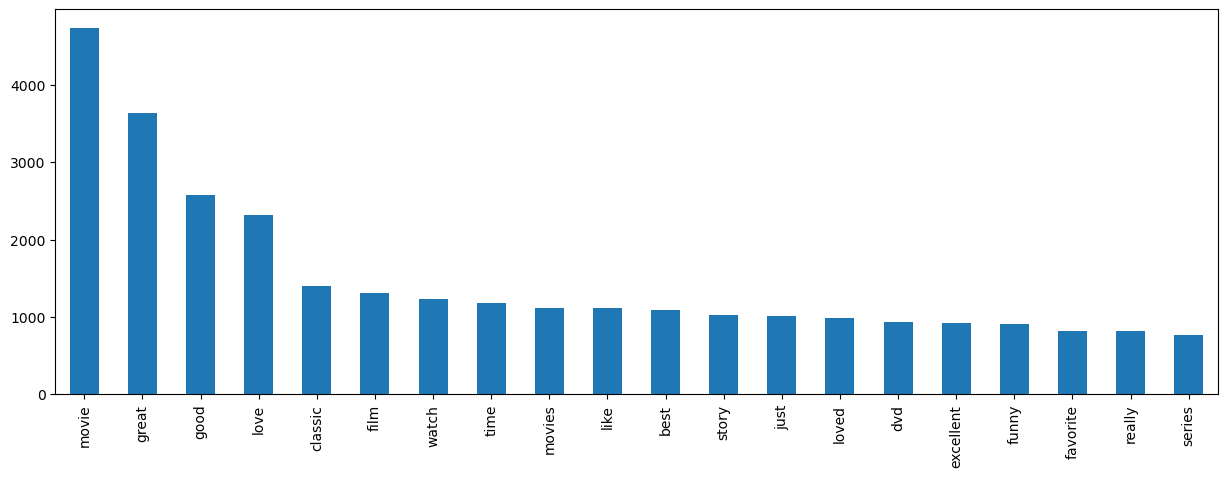

In [49]:
word_counts = pd.DataFrame({"counts":X_train_transformed.toarray().sum(axis=0)},
                          index = review_wordbank.get_feature_names()
                          ).sort_values("counts",ascending= False)

word_counts.head(20).plot(kind="bar",figsize=(15,5), legend = False)

plt.show()

In [50]:
X_train_transformed = X_train_transformed.toarray()
X_test_transformed = X_test_transformed.toarray()

In [51]:
X_train['asin'].value_counts()

B00006CXSS    901
6305837325    585
B00005JLF2    384
7880879625    266
6304994567    237
             ... 
B00008HCA1      1
B00009UW0U      1
B000087F0L      1
B000067D0Z      1
B000094J5Z      1
Name: asin, Length: 3732, dtype: int64

# 5. Advanced Models <a class ='anchor' id='5AdvancedModels'></a>

**REMEMBER TO SCALE THE DATA**

In [53]:
from sklearn.preprocessing import StandardScaler

# Instantiate
standscaler = StandardScaler()
standscaler.fit(X_train_transformed)

X_train_scaled = standscaler.transform(X_train_transformed)

In [54]:
X_test_scaled = standscaler.transform(X_test_transformed)

## Logistic Regression

In [55]:
# Instantiate
logreg = LogisticRegression(C = 0.1)

# Fit the model
logreg.fit(X_train_scaled,y_train)

# Score the model
print(f"Train score: {logreg.score(X_train_scaled,y_train)}")
print(f"Test score: {logreg.score(X_test_scaled,y_test)}")

C:\Users\jason\anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train score: 0.9380221091639972
Test score: 0.8672099486551416


## Decision Tree Classification

In [56]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate
decisiontree_model = DecisionTreeClassifier(max_depth = 25)

# Fit the model
decisiontree_model.fit(X_train_transformed,y_train)

# Score the model
print(f"Train score: {decisiontree_model.score(X_train_transformed,y_train)}")
print(f"Test score: {decisiontree_model.score(X_test_transformed,y_test)}")

KeyboardInterrupt: 

## Support Vector Machine Classification

In [ ]:
from sklearn.svm import SVC

# Instantiate
svm_model = SVC(kernel='rbf')

# Fit the model
svm_model.fit(X_train_transformed,y_train)

# Score the model
print(f"Train score: {svm_model.score(X_train_transformed,y_train)}")
print(f"Train score: {svm_model.score(X_train_transformed,y_train)}")
print(f"Test score: {svm_model.score(X_test_transformed,y_test)}")

In [ ]:
#review_transformed.toarray().sum(axis=0)

Use grid search to determine the best model and hyperparameter

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

estimators = [('normalize', StandardScaler()),
             ('svm', )]

Build grid search 
Make models notebook with just numeric data
NLP notebook models with text analysis

Recommendation
